In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import netCDF4
from global_land_mask import globe
from scipy.optimize import curve_fit
import matplotlib as mpl
import nc_time_axis
mpl.rcParams['figure.dpi']= 300

In [116]:
#CERES
k = '/media/rakshith/Seagate Expansion Drive/mraks/CERES.nc'
ds1 = xr.open_mfdataset(k)

In [117]:
jjas = ds1.time.dt.month.isin(range(6, 10)) #JJAS
clim = ds1.sel(time=jjas, lat=slice(10,30), lon=slice(70,90))
net = clim.toa_net_all_mon.groupby('time.year').mean('time')

In [118]:
lon_grid1, lat_grid1 = np.meshgrid(net.lon, net.lat)
ceresmask = globe.is_land(lat_grid1, lon_grid1)

In [119]:
#ERA
h = '/media/rakshith/Seagate Expansion Drive/mraks/TGMS ERA 1959-2021, India only.nc'
ds2 = xr.open_dataset(h)

lon_grid, lat_grid = np.meshgrid(ds2.longitude, ds2.latitude)
eramask = globe.is_land(lat_grid, lon_grid)

In [120]:
jjas = ds2.time.dt.month.isin(range(6, 10)) #JJAS
clim = ds2.sel(time=jjas)
clim = clim.groupby('time.year').mean('time')
clim3 = clim.where(eramask>0).mean(dim=['latitude', 'longitude'])

In [121]:
#IMD
path = '/media/rakshith/Seagate Expansion Drive/IMD' #Daily dataset 
fi = '/RFone_imd_rf_1x1_*.nc'
ds3=xr.open_mfdataset(path+fi)

In [122]:
lat1, lat2, lon1, lon2 = 10, 30, 70, 90
imd2 = ds3.sel(LATITUDE=slice(lat1,lat2), LONGITUDE=slice(lon1,lon2))

months = imd2.TIME.dt.month.isin(range(6, 10))
imd3 = imd2.sel(TIME=months)
imd3 = imd3.groupby('TIME.year').mean('TIME')

lon_grid, lat_grid = np.meshgrid(imd2.LONGITUDE, imd2.LATITUDE) #creating a land sea mask
imdmask = globe.is_land(lat_grid, lon_grid)

In [132]:
Qnet = net.where(ceresmask>0).mean(dim=['lat', 'lon'])
E = -86400*clim3.mer.sel(year=slice(2000, 2021))
Prec = imd3.RAINFALL.sel(year=slice(2000, 2021)).where(imdmask>0).mean(dim=['LONGITUDE', 'LATITUDE'])

In [133]:
TGMS1 = Qnet/(28.96*(Prec-E))

In [134]:
Pint = (Prec-E).values
Qint = Qnet.values/28.96
Gint = TGMS1.values

print(np.max(Pint), np.argmax(Pint))
print(np.min(Pint), np.argmin(Pint))


Q = np.average(Qint)
P = np.average(Pint)
G = Q/P

#yearly contribution
dQ = []
dG = []
for i in range(len(Pint)):
	dQ.append(Qint[i]-Q)
	dG.append(Gint[i]-G)


dP = []
Qcont = []
Tcont = []
for i in range(len(Pint)):
	Qcont.append((dQ[i]*Pint[i]/Q)/(1+(dG[i]/G)))
	Tcont.append((-dG[i]*Pint[i]/G)/(1+(dG[i]/G)))
	dP.append(Pint[i]-P)

sum = np.add(Tcont, Qcont).tolist()

4.995539917944088 19
2.413736921517657 9


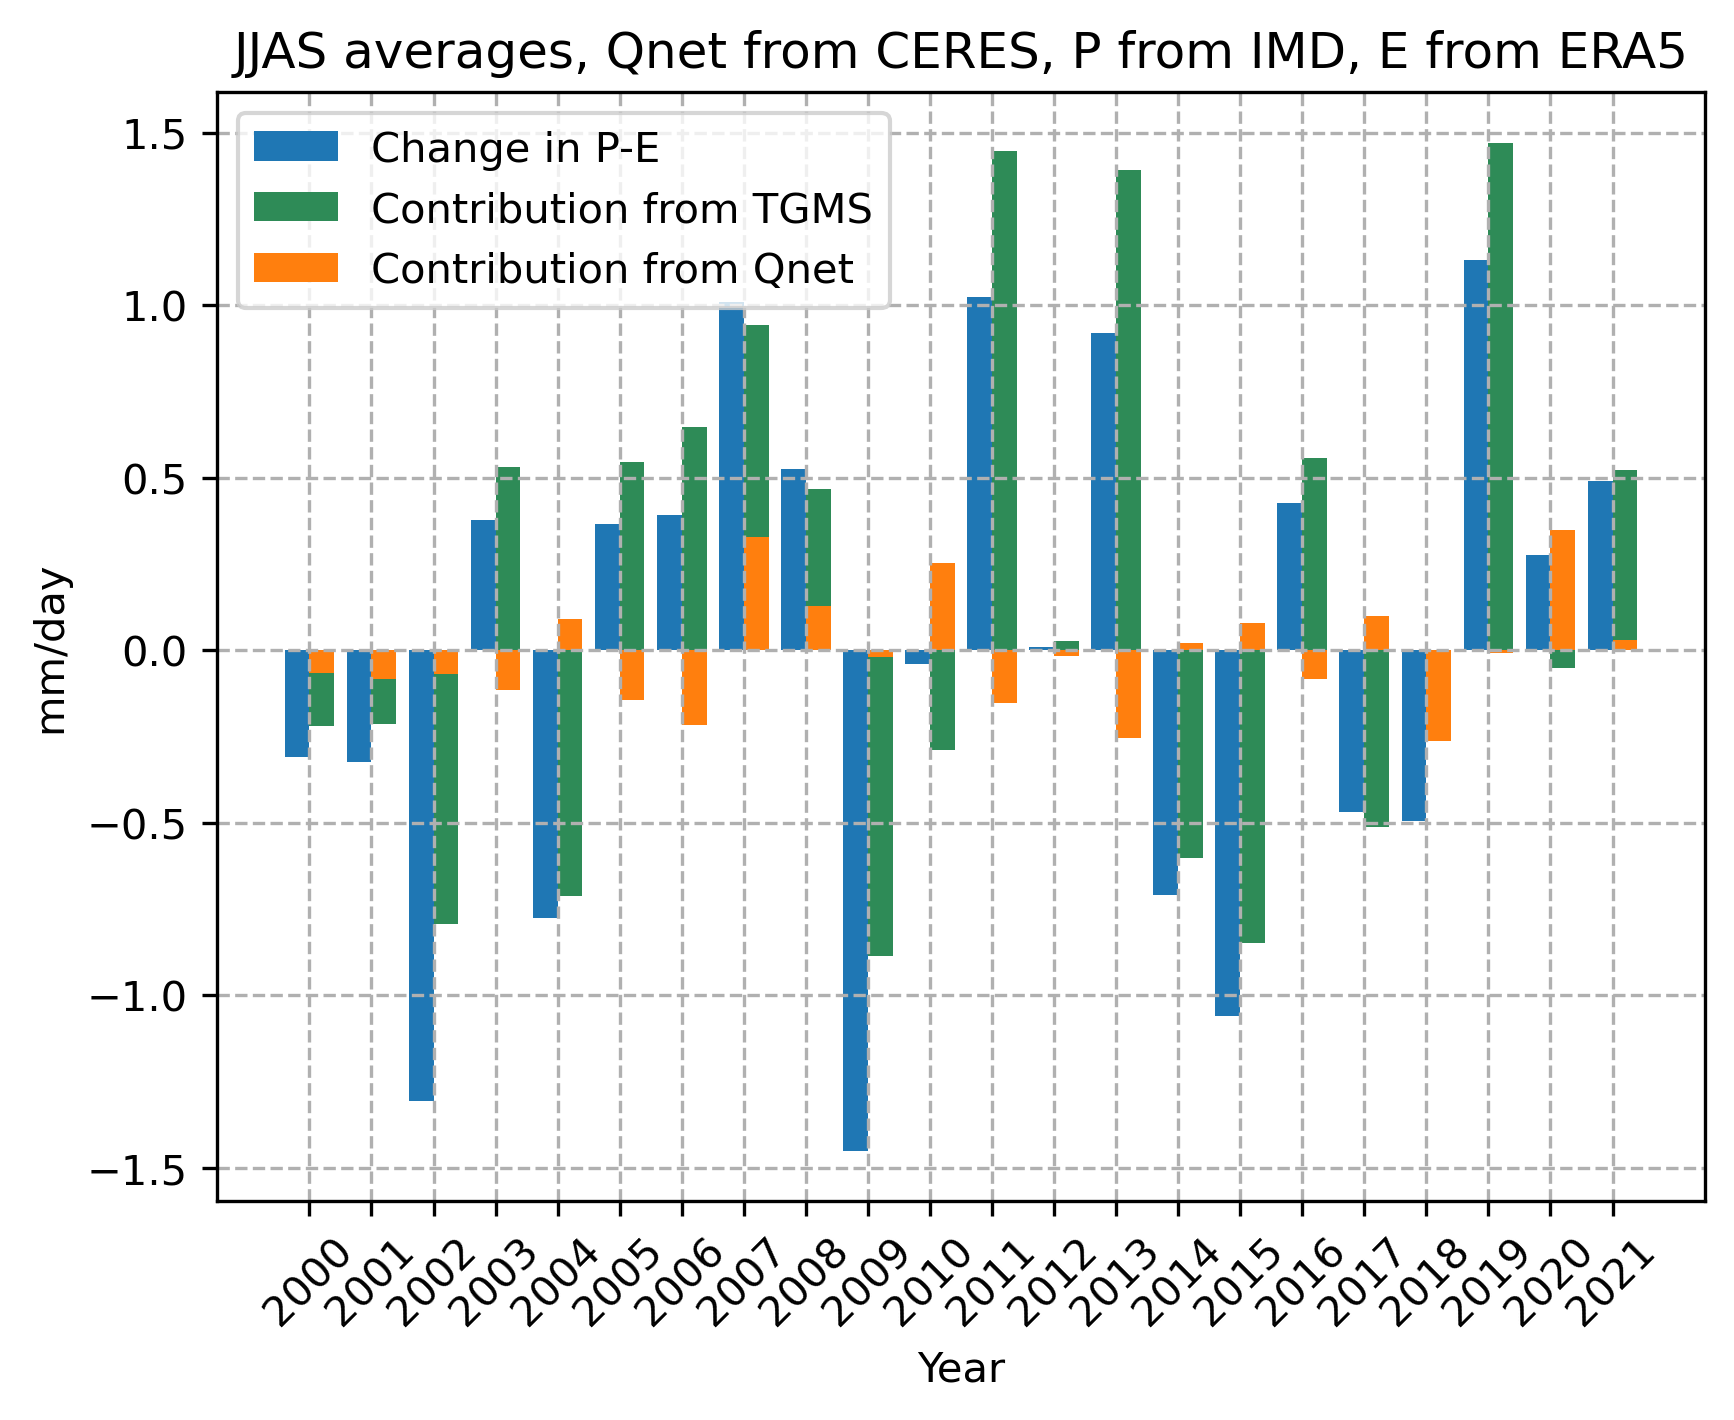

In [135]:
X = E.year.values

arr = np.array(dP)
ind = X # the x locations for the groups
width = 0.4     # the width of the bars

plt.bar(ind-width/2, dP, width)
plt.bar(ind+width/2, Tcont, width, color='seagreen')
plt.bar(ind+width/2, Qcont, width, color='tab:orange')
plt.xticks(X, X, rotation=45)        #shows all the x labels
plt.xlabel('Year')
plt.ylabel('mm/day')
plt.title('JJAS averages, Qnet from CERES, P from IMD, E from ERA5')
plt.legend(['Change in P-E', 'Contribution from TGMS', 'Contribution from Qnet']) 
plt.grid(linestyle='--')
plt.show()

In [136]:
ERA = clim3.sel(year=slice(2000, 2021))

In [137]:
Pera = 86400*ERA.mtpr
Qdiv = ERA.mtnswrf + ERA.mtnlwrf

In [138]:
TGMS2 = Qdiv/(28.96*(Pera-E))

In [139]:
Pint = (Pera-E).values
Qint = Qdiv.values/28.96
Gint = TGMS2.values

print(np.max(Pint), np.argmax(Pint))
print(np.min(Pint), np.argmin(Pint))


Q = np.average(Qint)
P = np.average(Pint)
G = Q/P

#yearly contribution
dQ = []
dG = []
for i in range(len(Pint)):
	dQ.append(Qint[i]-Q)
	dG.append(Gint[i]-G)


dP = []
Qcont = []
Tcont = []
for i in range(len(Pint)):
	Qcont.append((dQ[i]*Pint[i]/Q)/(1+(dG[i]/G)))
	Tcont.append((-dG[i]*Pint[i]/G)/(1+(dG[i]/G)))
	dP.append(Pint[i]-P)

sum = np.add(Tcont, Qcont).tolist()

5.684120371006429 19
3.2610838883556426 2


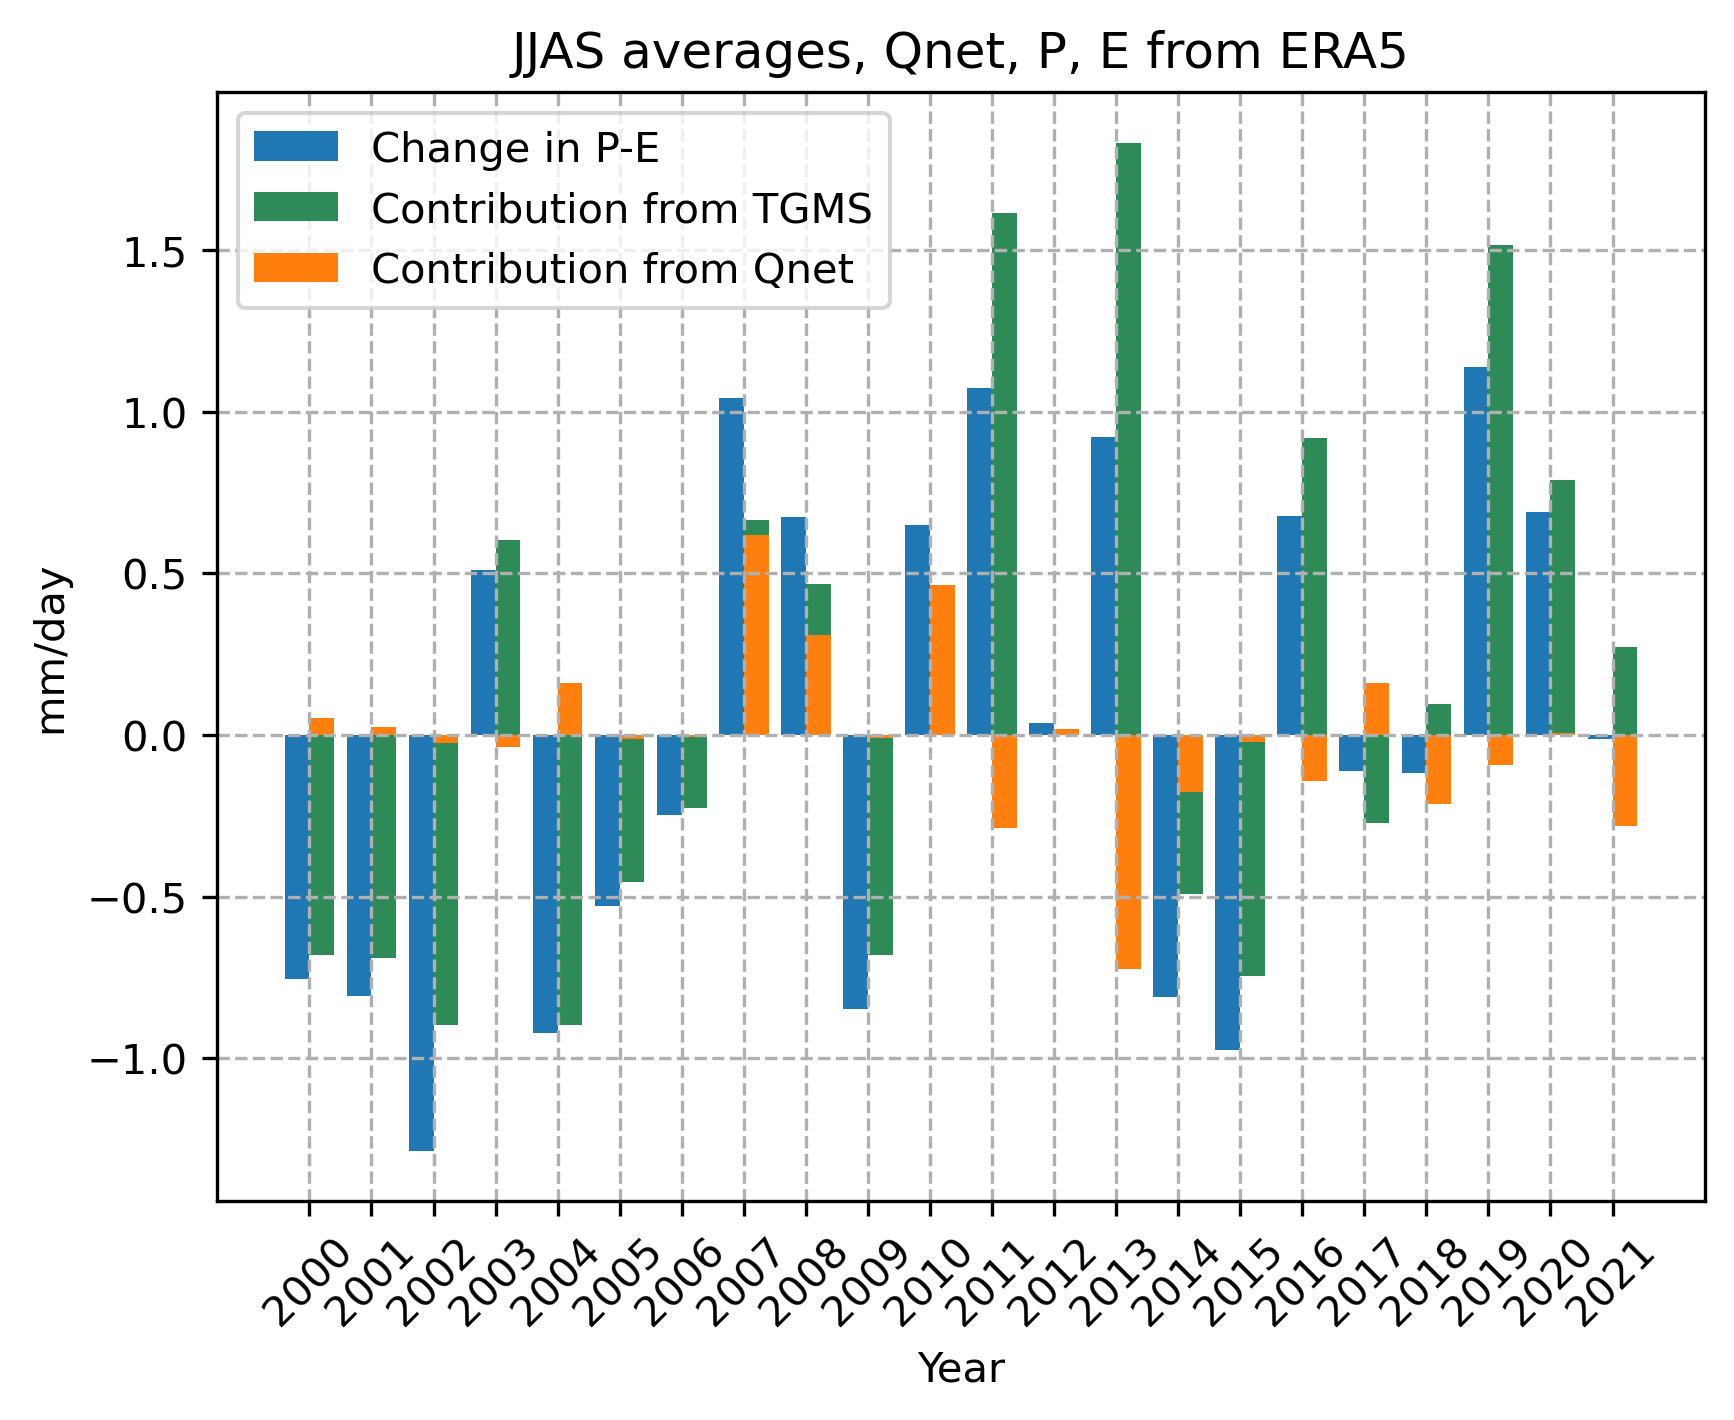

In [140]:
X = E.year.values

arr = np.array(dP)
ind = X # the x locations for the groups
width = 0.4     # the width of the bars

plt.bar(ind-width/2, dP, width)
plt.bar(ind+width/2, Tcont, width, color='seagreen')
plt.bar(ind+width/2, Qcont, width, color='tab:orange')
plt.xticks(X, X, rotation=45)        #shows all the x labels
plt.xlabel('Year')
plt.ylabel('mm/day')
plt.title('JJAS averages, Qnet, P, E from ERA5')
plt.legend(['Change in P-E', 'Contribution from TGMS', 'Contribution from Qnet']) 
plt.grid(linestyle='--')
plt.show()